In [1]:
# PyTorch Imports
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Normal

# Basic Python Imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Module Imports
from Modules.BayesLinear import BayesLinear
from Modules.Loss import BKLLoss
from Modules.BayesHarry import BayesLinear as BayesHarry

import random
from sklearn.preprocessing import StandardScaler

random.seed(10)

### Load data
Format for Bayesian NN. Visualisation of the time series.

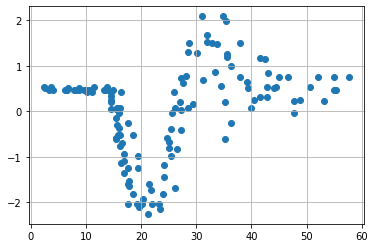

X : torch.Size([133, 1]) Y : torch.Size([133, 1, 1])


In [2]:
# Load data
data = pd.read_csv('Data/motorcycle.csv')

# Conversion to float tensors 
x = np.array(data['times'])
y = np.array(data['accel'])

#y = StandardScaler().fit_transform(y.reshape(-1,1))
x = torch.unsqueeze(torch.from_numpy(x), dim=1)
#y = torch.from_numpy(y)

y = StandardScaler().fit_transform(y.reshape(-1,1))
y = torch.unsqueeze(torch.from_numpy(y), dim=1)

x = x.float()
y = y.float()

x_np = x.squeeze().numpy()
y_np = y.squeeze().numpy()

# Plotting the timeseries
plt.figure()
plt.scatter(x, y)
plt.grid()
plt.show()

print('X :', x.shape, 'Y :', y.shape)

### Genetate Additional Data

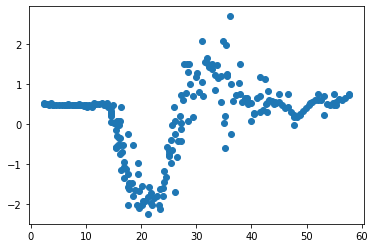

In [3]:
gp_mean = [0.5107,0.5032, 0.4939, 0.4843, 0.4765, 0.4718, 0.4713, 0.4748, 0.4805, 0.4856,
0.4870, 0.4824, 0.4724, 0.4604, 0.4523, 0.4543, 0.4695, 0.4953, 0.5216, 0.5319,
0.5067, 0.4284, 0.2868, 0.0825, -0.1722, -0.4559, -0.7433, -1.0112, -1.2435, -1.4339,
-1.5851, -1.7049, -1.8015, -1.8788, -1.9333, -1.9549, -1.9298, -1.8453, -1.6947, -1.4804,
-1.2140, -0.9140, -0.6013, -0.2950, -0.0080, 0.2536, 0.4900, 0.7046, 0.9006, 1.0778,
1.2317, 1.3542, 1.4362, 1.4710, 1.4573, 1.4012, 1.3147, 1.2139, 1.1143, 1.0277,
0.9589, 0.9056, 0.8605, 0.8146, 0.7605, 0.6959, 0.6241, 0.5533, 0.4935, 0.4538,
0.4395, 0.4501, 0.4795, 0.5173, 0.5507, 0.5678, 0.5600, 0.5241, 0.4632, 0.3869,
0.3092, 0.2456, 0.2098, 0.2103, 0.2482, 0.3164, 0.4015, 0.4868, 0.5568, 0.6006,
0.6147, 0.6033, 0.5769, 0.5487, 0.5311, 0.5324, 0.5549, 0.5950, 0.6441, 0.6919,
0.7285]

gp_stddev = [0.0477, 0.0400, 0.0463, 0.0514, 0.0529, 0.0502, 0.0438, 0.0366, 0.0330,0.0328, 0.0327,
0.0318, 0.0315, 0.0331, 0.0363, 0.0433, 0.0560, 0.0702, 0.0780, 0.0733, 0.0615, 0.0799,
0.1468, 0.2393, 0.3408, 0.4382, 0.5196, 0.5747, 0.5959, 0.5800, 0.5295, 0.4540, 0.3712,
0.3067, 0.2822, 0.2915, 0.3074, 0.3135, 0.3156, 0.3360, 0.3899, 0.4658, 0.5385, 0.5873,
0.6045, 0.5975, 0.5860, 0.5901, 0.6133, 0.6377, 0.6380, 0.5951, 0.5022, 0.3669, 0.2227,
0.1980, 0.3483, 0.5319, 0.6956, 0.8186, 0.8886, 0.8987, 0.8470, 0.7373, 0.5789, 0.3876,
0.1898, 0.1067, 0.2472, 0.3799, 0.4620, 0.4847, 0.4492, 0.3643, 0.2463, 0.1253, 0.1068,
0.2006, 0.2817, 0.3230, 0.3195, 0.2769, 0.2092, 0.1377, 0.0911, 0.0856, 0.0919, 0.0940,
0.1116, 0.1568, 0.2117, 0.2548, 0.2730, 0.2623, 0.2282, 0.1857, 0.1545, 0.1445, 0.1445,
0.1437, 0.1542]

y_sample = []
x_sample = np.linspace(min(x_np), max(x_np), len(gp_mean))

y_sample = [np.random.normal(gp_mean[i], gp_stddev[i]**2, 1) for i in range(len(gp_mean))]
    

x_new = np.append(x_np, x_sample)
y_new = np.append(y_np, y_sample)

plt.scatter(x_new, y_new)
plt.show()

idx = np.argsort(x_new)
x_sorted = x_new[idx]
y_sorted = y_new[idx]

x = torch.unsqueeze(torch.from_numpy(x_sorted), dim=1)
y = torch.unsqueeze(torch.from_numpy(y_sorted), dim=1)

x = x.float()
y = y.float()

### Model

In [4]:
class Net(Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        #self.hidden1 = nn.Linear(in_features=n_feature, out_features=n_hidden, bias=True)
        #self.hidden2 = nn.Linear(in_features=n_hidden, out_features=n_hidden, bias=True)
        #self.predict = nn.Linear(in_features=n_hidden, out_features=n_output, bias=True)
        self.hidden1 = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_feature, out_features=n_hidden, bias=True)   # hidden layer
        self.hidden2 = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_hidden, bias=True)
        self.predict = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_output, bias=True)   # output layer
        
        #self.mean_est = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_output, bias=True)
        #self.logvar_est = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_output, bias=True)
        
    def forward(self, x):
        x = torch.tanh(self.hidden1(x))      # activation function for hidden layer
        x = torch.tanh(self.hidden2(x))
        x = self.predict(x)              # linear output
        
        mu, log_std = x.chunk(2, dim=1)
        
        dist = Normal(mu, torch.exp(log_std))
        #mean = self.mean_est(x)
        #log_var = self.logvar_est(x)
        
        #return mean, log_var
        return dist
    
net = Net(n_feature=1, n_hidden=50, n_output=2)     # define the network
print(net)  # net architecture

Net(
  (hidden1): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=50, bias=True)
  (hidden2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=50, out_features=50, bias=True)
  (predict): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=50, out_features=2, bias=True)
)


### BNN - With Aleatoric Uncertainty

In [8]:
net = net.float()

optimizer = optim.Adam(net.parameters(),  lr=0.001)

kl_loss = BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

#mse_loss = nn.MSELoss()

for t in range(50000):
    
    optimizer.zero_grad()
    
    #mean, log_var = net(x)
    distribution = net(x.float())
    
    kl = kl_loss(net)
    
    #mse = mse_loss(prediction[:,0], y.float().squeeze())
    #distribution = Normal(mean, var)
    
    #nll = -1/2 * torch.log(2*math.pi*var) - (y.float()-mean)**2 / (2*var)
    #cost = -nll.sum() + kl_weight*kl
    #cost = -distribution.log_prob(y.float()).sum() #+ kl_weight*kl
    cost = -distribution.log_prob(y.float()).sum(1).mean() + kl_weight*kl
    
    cost.backward()
    
    optimizer.step()
    
print('- MSE : %2.2f, KL : %2.2f' % (cost.item(), kl.item()))

- MSE : -0.23, KL : 4.70


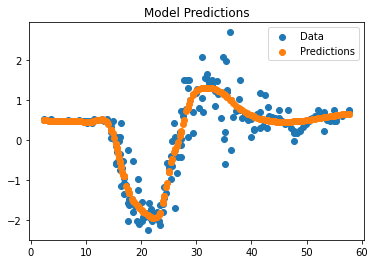

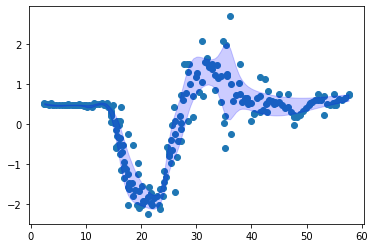

In [9]:
prediction = net(x.float())
mean = prediction.loc.squeeze().detach().numpy()
std = prediction.scale.squeeze().detach().numpy()

plt.figure()
plt.scatter(x, y, label='Data')
plt.scatter(x, mean, label='Predictions')
plt.title('Model Predictions')
plt.legend()
plt.show()

plt.figure()
plt.scatter(x, y)
plt.fill_between(x_sorted, mean - std, mean + std, color='b', alpha=0.2)
plt.show()

Implement mini-batches to speed up training process.

### Original BNN - Without Aleatoric Uncertainty

In [3]:
class Net(Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden1 = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_feature, out_features=n_hidden, bias=True)   # hidden layer
        self.hidden2 = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_hidden, bias=True)
        self.predict = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_output, bias=True)   # output layer
        
    def forward(self, x):
        x = torch.tanh(self.hidden1(x))      # activation function for hidden layer
        x = torch.tanh(self.hidden2(x))
        x = self.predict(x)              # linear output
        
        return x
    
net = Net(n_feature=1, n_hidden=100, n_output=1)     # define the network
print(net)  # net architecture

Net(
  (hidden1): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=100, bias=True)
  (hidden2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=100, bias=True)
  (predict): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=1, bias=True)
)


In [4]:
net = net.float()

optimizer = optim.Adam(net.parameters(), lr=0.01)
mse_loss = nn.MSELoss()

kl_loss = BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

for t in range(1000):
    
    optimizer.zero_grad()
    
    prediction = net(x.float())     # input x and predict based on x
    
    mse = mse_loss(prediction, y.float())
    
    kl = kl_loss(net)
    
    cost = mse + kl_weight*kl
    
    cost.float().backward()
    
    optimizer.step()
    
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

- MSE : 820.39, KL : 10.51


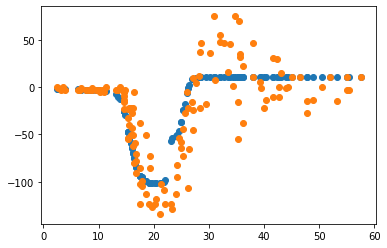

In [5]:
plt.figure()
plt.scatter(x, prediction.detach().numpy())
plt.scatter(x, y)
plt.show()